In [827]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import kde
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import random
random.seed(10)

In [767]:
calibration_data = pd.read_csv("R 2 sigurd/PCA_CALIBRATION_2.csv")

In [768]:
X_pd_data = calibration_data.iloc[:,4:406]


X = calibration_data.iloc[:,4:406].values
y = calibration_data.iloc[:,406].values

#Standardize
sc = StandardScaler()
X_std = sc.fit_transform(X)


In [769]:
#PCA
pca_model = PCA(n_components= 13)
pca_model.fit(X_std)
X_pca = pca_model.transform(X_std)

# VALIDATING R-studio results in Python using calibration/validation data. 

First we will calculate mean AUC scores across cross validation. 

In [770]:
lda = LinearDiscriminantAnalysis()
#kf = KFold(n_splits= 10, shuffle= True)

kf = StratifiedKFold(n_splits= 10 , shuffle= True)


roc_scores_list = []

for i in range(20):
    for train, test in kf.split(X_pca, y):
        lda.fit(X_pca[train,:], y[train])
        y_score_lda1 = lda.decision_function(X_pca[test,:])
        roc_scores_list.append(roc_auc_score(y[test], y_score_lda1))
    print(np.mean(roc_scores_list))

0.8690441762931324
0.8686747779186634
0.8687864756705481
0.8688677516245125
0.8686609522393972
0.868832556804652
0.8687849599649731
0.8687748848286478
0.8688088463216057
0.8688405564225807
0.8688378320951216
0.8688321816756066
0.8688376333166551
0.8688271228277761
0.8688338194508407
0.8688554876485503
0.8688257139516304
0.8688092362092605
0.868796626813916
0.8688214153245473


#### Cross-val with different n-PCA features. 

In [771]:
def n_pca_try(X, y, max_n): 
    lda = LinearDiscriminantAnalysis()
    n_feat = []
    for i in range(2,max_n):
        pca_model = PCA(n_components= i)
        sc = StandardScaler()
        kf = StratifiedKFold(n_splits= 10 , shuffle= True)

        roc_scores_list = []
        for train, test in kf.split(X, y):
            #std
            X_train_std = sc.fit_transform(X[train,])
            X_test_std = sc.transform(X[test,])
            #Pca 
            X_train_pca = pca_model.fit_transform(X_train_std)
            X_test_pca = pca_model.transform(X_test_std)
            #Lda
            lda.fit(X_train_pca, y[train])
            y_score_lda1 = lda.decision_function(X_test_pca)
            roc_scores_list.append(roc_auc_score(y[test], y_score_lda1))
        
        n_feat.append(np.mean(roc_scores_list))
        #print(np.mean(roc_scores_list))   

    return(n_feat) 


In [772]:
#FUll model only
AUC_DIFF_PCA = n_pca_try(X, y, 150)

<function matplotlib.pyplot.show(close=None, block=None)>

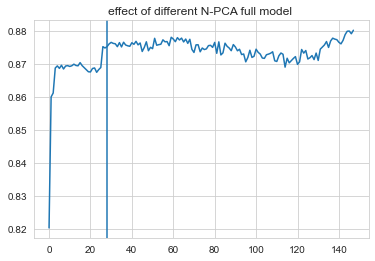

In [773]:
plt.plot(AUC_DIFF_PCA)
plt.axvline(28)
plt.title("effect of different N-PCA full model ")
plt.show

## Test different Number of pca features on Velocity, Acceleration and coordinates.



In [786]:
#get index
#Vel
indx_start_vel = X_pd_data.columns.get_loc('v002') 
indx_end_vel = X_pd_data.columns.get_loc('v101')
#acc
indx_start_acc = X_pd_data.columns.get_loc('a002') 
indx_end_acc = X_pd_data.columns.get_loc('a101')
#Coord
indx_start_coord = X_pd_data.columns.get_loc('x001') 
indx_end_coord = X_pd_data.columns.get_loc('y101')


#get X_vel X_acc and Coord
X_vel = X[:, indx_start_vel:indx_end_vel] 
X_acc = X[:, indx_start_acc:indx_end_acc]
X_coord = X[:, indx_start_coord:indx_end_coord]

#VEl ACC
X_vel_acc = np.concatenate((X_vel,X_acc),axis=1)
#Coord vel
X_coord_vel = np.concatenate((X_coord, X_vel), axis = 1)

In [787]:
n_pca_vel = n_pca_try(X_vel, y, 80)
n_pca_acc = n_pca_try(X_acc, y, 80)
n_pca_coord = n_pca_try(X_coord,y , 80)
n_pca_vel_acc = n_pca_try(X_vel_acc, y , 80)




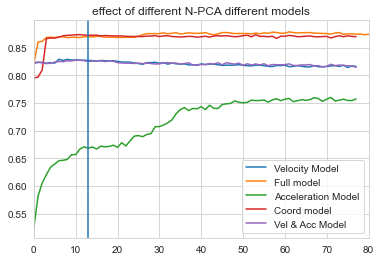

In [285]:
plt.plot(n_pca_vel, label = "Velocity Model")
plt.plot(AUC_DIFF_PCA, label = "Full model")
plt.plot(n_pca_acc, label = "Acceleration Model")
plt.plot(n_pca_coord, label = "Coord model")
plt.plot(n_pca_vel_acc, label = "Vel & Acc Model")

plt.axvline(13)
plt.xlim(0, 80)
plt.title("effect of different N-PCA different models")
plt.legend()
plt.show()

In [286]:
y_2 = np.zeros(shape = len(y))
for i in range(len(y)):
    if y[i] == "Central": #Central = STRAIGHT = NOT DEVIATED / CONTROL
        y_2[i] = 0
    else: 
        y_2[i] = 1


In [816]:
def CV_train(n_compon, data, labels):
    sc = StandardScaler()
    pc = PCA(n_components= n_compon)

    lda = LinearDiscriminantAnalysis()
    kf = StratifiedKFold(n_splits= 10 , shuffle= True)

    #lists
    roc_scores_list = []
    
    for train, test in kf.split(data, labels):
        #std 
        data_std_train = sc.fit_transform(data[train]) 
        data_std_test = sc.transform(data[test])
        
        #PCA
        data_pca_train = pc.fit_transform(data_std_train)
        data_pca_test = pc.transform(data_std_test)

        lda.fit(data_pca_train, labels[train])
        y_score_lda1 = lda.decision_function(data_pca_test)
        roc_scores_list.append(roc_auc_score(labels[test], y_score_lda1))
    return(roc_scores_list)



In [817]:
data_frame_CV_model_calibration = pd.DataFrame({
    "CV Iteration": range(1,11),
    "full_model": CV_train(n_compon= 13, data= X, labels = y_2),
    "coord_model": CV_train(n_compon= 13, data = X_coord, labels = y_2),
    "vel_model": CV_train(n_compon= 13, data= X_vel, labels= y_2),
    "acc_model": CV_train(n_compon= 13, data = X_acc, labels = y_2),
    "vel acc model": CV_train(n_compon= 13, data = X_vel_acc, labels = y_2),
    "coord vel model": CV_train(n_compon= 13, data = X_coord_vel, labels = y_2)        
})







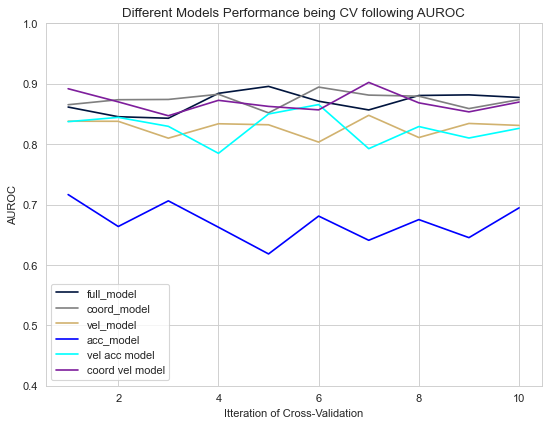

In [820]:
from scipy.interpolate import make_interp_spline, BSpline

colors = ["OK","#01153E", "#808080", "#D1B26F", "#0000FF","#00FFFF", "#7E1E9C", ]

plt.figure(figsize=(8, 6), dpi=80)
for i in range(1,7):
    x_new = np.linspace(data_frame_CV_model_calibration.iloc[:,0].min(), data_frame_CV_model_calibration.iloc[:,0].max(), 10)
    y = data_frame_CV_model_calibration.iloc[:,i]
    #spline 
    spl = make_interp_spline(data_frame_CV_model_calibration.iloc[:,0], y, k = 2)
    y_smooth = spl(x_new)
    
    plt.plot(x_new, y_smooth, label = data_frame_CV_model_calibration.columns[i], color = colors[i])

    #plt.plot(data_frame_CV_model_calibration.iloc[:,0], data_frame_CV_model_calibration.iloc[:,i], label = data_frame_CV_model_calibration.columns[i])
plt.title("Different Models Performance being CV following AUROC")
plt.ylabel("AUROC")
plt.xlabel("Itteration of Cross-Validation")
plt.ylim(0.4, 1)
plt.legend()
plt.savefig('cross_val_different_models.png', dpi  = 1000)
plt.show()

## Create the ROC curve 

Creating ROC curves for validation/calibration data with all features included. 

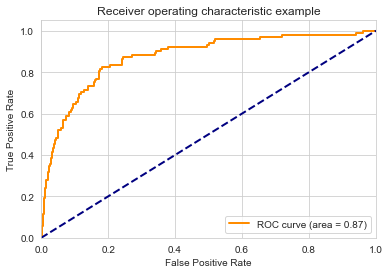

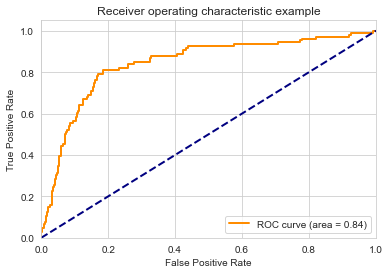

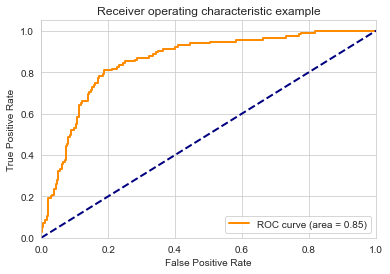

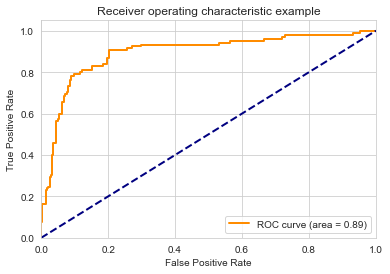

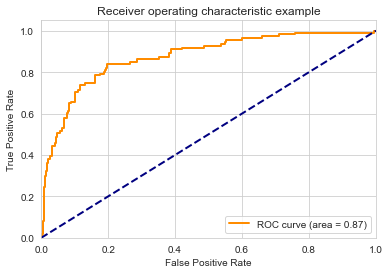

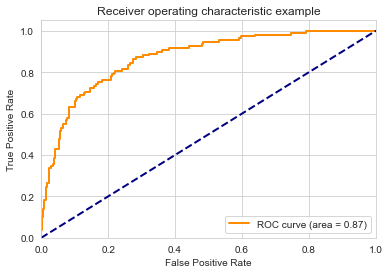

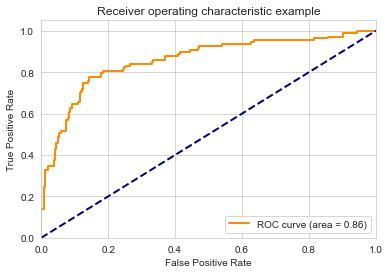

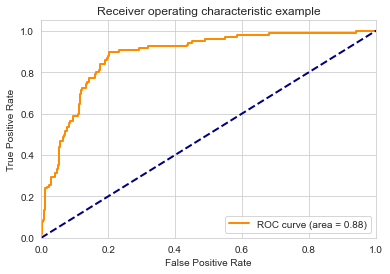

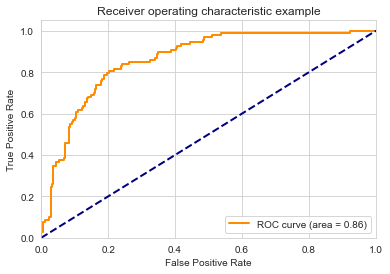

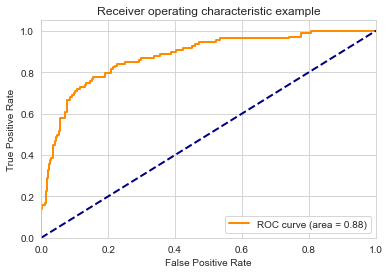

In [330]:
lda = LinearDiscriminantAnalysis()
kf = KFold(n_splits= 10, shuffle= True)


for train, test in kf.split(X_pca):
    lda.fit(X_pca[train,:], y_2[train])
    y_score_lda1 = lda.decision_function(X_pca[test,:])
    fpr, tpr, _ = roc_curve(y_2[test], y_score_lda1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr,tpr,
        color="darkorange",lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

## Replicating Test of Calibration on Negation. 

In [253]:
negation_data = pd.read_csv("R 2 sigurd/Sigurd_Negation_PCA_data.csv")
#filter for true
negation_data_true = negation_data[negation_data["Response"] == True]


In [270]:
#Get X
negation_X_start = negation_data_true.columns.get_loc('x001') 
X_negation_true = negation_data_true.iloc[:,negation_X_start:410].values


#std
sc = StandardScaler()
sc.fit(X)
X_negation_std = sc.transform(X_negation_true)

#pca 
pca_model = PCA(n_components= 13)
pca_model.fit(X_std)
X_negation_pca = pca_model.transform(X_negation_std)


#Get Y
Y_negation_true = negation_data_true.iloc[:,3].values

#turn y numeric 0 = Not deviated,  1 = deviated. 
y_negation_true_2 = np.zeros(shape = len(Y_negation_true))
for i in range(len(Y_negation_true)):
    if Y_negation_true[i] == "P": #Central = STRAIGHT = NOT DEVIATED / CONTROL
        y_negation_true_2[i] = 0
    else: 
        y_negation_true_2[i] = 1

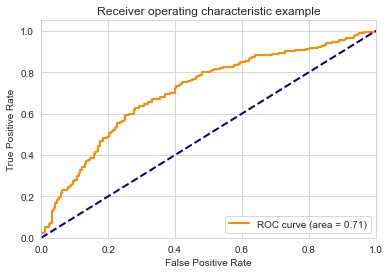

0.7074486599373477


In [274]:



## Getting ROC curve for negation

lda = LinearDiscriminantAnalysis()

lda.fit(X_pca, y_2)
y_score_lda1 = lda.decision_function(X_negation_pca)
fpr, tpr, _ = roc_curve(y_negation_true_2, y_score_lda1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr,tpr,
    color="darkorange",lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

#AUC SCORE for ROC curve
print(roc_auc_score(y_negation_true_2, y_score_lda1))

### ISSUE OF THEM NOT HAVING STANDARDIZED THEIR VELOCITY AND ACCELERATION values.  (FIXED) 
All variables need's to be standardized and normalized when doing PCA. 

I will now proceed by doing exactly that followed up with another evaluation of the AUC score. 

# **Testing their lda and pca model on our spivey replication data.** 

In [751]:
#Load data and prepare

spivey_data = pd.read_csv("R 2 sigurd/spivey_data_for_pca.csv")


#X
X_spivey = spivey_data.iloc[:,4:407]
X_spivey['a101'] = 0
X_spivey_ndarray = X_spivey.values


#std
sc = StandardScaler()
sc.fit(X) #FIT STANDARDIZER ON X(CALIBRATION DATA) or Spivey_data(Our data). fit() on X performs better. 
X_spivey_std = sc.transform(X_spivey)

#pca 
pca_model = PCA(n_components= 13)
pca_model.fit(X_std)
X_spivey_pca = pca_model.transform(X_spivey_std)



/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [420]:
#Y find Polarity. 
y_spivey = spivey_data.iloc[:,2]
#Prepare array.
y_spivey2 = np.zeros(shape = len(y_spivey))

# Y as numeric. 1 = devitation/cohort,   0 = No Deviation/Control
for i in range(len(y_spivey)):
    if y_spivey[i] == "cohort":
        y_spivey2[i] = 1
    else: 
        y_spivey2[i] = 0

np.unique(y_spivey, return_counts= True)

In [423]:
# LDA Fit on Calibration test on Spivey

#fit 
lda = LinearDiscriminantAnalysis()
lda.fit(X_pca, y_2)

#predict on Spivey data 
lda.predict(X_spivey_pca)
lda.score(X_spivey_pca, y_spivey2)



#get lda values. 
spivey_data["lda_value"] = lda.transform(X_spivey_pca)


In [425]:
predict_list = lda.predict(X_spivey_pca)

np.unique(predict_list, return_counts= True)


(array([0., 1.]), array([859,  23]))

In [426]:
# Find mean lda_value with se for both Polarities. 
from scipy.stats import sem

d = {'means': [spivey_data.loc[spivey_data["Polarity"] == "control", "lda_value"].mean(), spivey_data.loc[spivey_data["Polarity"] != "control", "lda_value"].mean()], 
    "se": [sem(spivey_data.loc[spivey_data["Polarity"] == "control", "lda_value"]) ,sem(spivey_data.loc[spivey_data["Polarity"] != "control", "lda_value"])] }

pd.DataFrame(data = d)



,means,se
0,-3.495253,0.067185
1,-3.073786,0.086266


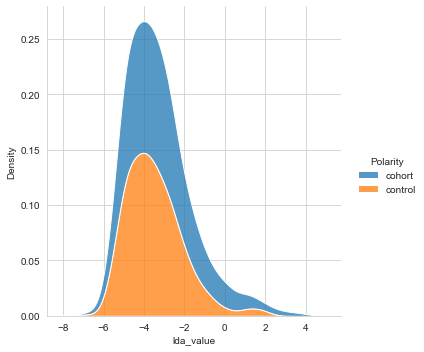

In [427]:
import seaborn as sns

sns.set_style('whitegrid')
sns.displot(spivey_data, x = "lda_value", hue = "Polarity", kind = "kde", multiple = "stack")



In [715]:
y_score_lda = lda.fit(X_pca, y_2).decision_function(X_spivey_pca) #fit on validation data # test on Spivey data

In [716]:
roc_auc_score(y_spivey2, y_score_lda)

0.55845538322294

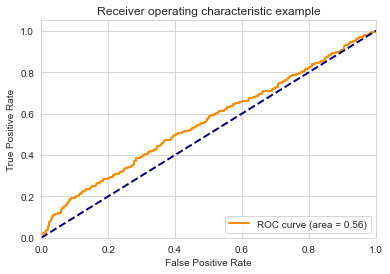

In [430]:
lda = LinearDiscriminantAnalysis()

lda.fit(X_pca, y_2)
y_score_lda1 = lda.decision_function(X_spivey_pca)
fpr, tpr, _ = roc_curve(y_spivey2, y_score_lda1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr,tpr,
    color="darkorange",lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [431]:
roc_auc

0.55845538322294

## How does different feature combinations perform on our model. 
Fitted and tested on our own data. 

In [764]:
#get index
#Vel
indx_start_vel = spivey_data.columns.get_loc('v002') 
indx_end_vel = spivey_data.columns.get_loc('v101')
#acc
indx_start_acc = spivey_data.columns.get_loc('a002') 
indx_end_acc = spivey_data.columns.get_loc('a101')
#Coord
indx_start_coord = spivey_data.columns.get_loc('x001') 
indx_end_coord = spivey_data.columns.get_loc('y101')


#get X_vel X_acc and Coord
X_vel_spivey = spivey_data.iloc[:, indx_start_vel:indx_end_vel].values 

X_acc_spivey = spivey_data.iloc[:, indx_start_acc:indx_end_acc].values

X_coord_spivey = spivey_data.iloc[:, indx_start_coord:indx_end_coord].values

X_vel_acc_spivey = np.concatenate((X_vel_spivey,X_acc_spivey),axis=1)

In [765]:
#Different models with different number of PCA features. 
X_vel_acc_list = n_pca_try(X_vel_acc_spivey, y_spivey2, max_n = 80)

X_vel_list = n_pca_try(X_vel_spivey, y_spivey2, 80)

X_acc_list = n_pca_try(X_acc_spivey, y_spivey2, 80)

X_coord_list = n_pca_try(X_coord_spivey, y_spivey2, 80)

X_all_list = n_pca_try(X_spivey_ndarray, y_spivey2, 80)

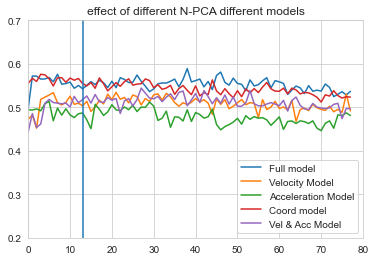

In [436]:
plt.plot(X_all_list, label = "Full model")
plt.plot(X_vel_list, label = "Velocity Model")
plt.plot(X_acc_list, label = "Acceleration Model")
plt.plot(X_coord_list, label = "Coord model")
plt.plot(X_vel_acc_list, label = "Vel & Acc Model")
plt.axvline(13)
plt.xlim(0, 80)
plt.title("effect of different N-PCA different models")
plt.legend()
plt.ylim(0.20,0.70)
plt.show()

In [658]:
#Function for testing different X feature matrixes. 

def train_test(n_compon, data_train , data_test, y_train, y_test):
    sc = StandardScaler()
    pc = PCA(n_components = n_compon)
    lda = LinearDiscriminantAnalysis()

    #Standardize
    train_sc = sc.fit_transform(data_train)
    test_sc = sc.transform(data_test)

    #PCA 
    train_pc = pc.fit_transform(train_sc)
    test_pc = pc.transform(test_sc)


    #lda
    lda.fit(train_pc, y_train)
    lda_score_y_test = lda.decision_function(test_pc)
    fpr, tpr, _  = roc_curve(y_test , lda_score_y_test)
    auc_score = auc(fpr, tpr)

    return auc_score


train_test(n_compon= 13, data_train= X, data_test= X_spivey, y_train= y_2, y_test= y_spivey2)

/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


0.5584193853622412

In [752]:
spivey_all_measures = pd.read_csv("R 2 sigurd/spivey_data_for_python.csv")

spivey_all_measures.describe()


,Subject,Item.number,x001,x002,x003,x004,x005,x006,x007,x008,...,MD_below_time,AD,AUC,xpos_flips,ypos_flips,xpos_reversals,ypos_reversals,RT,initiation_time,idle_time
count,882.000000,882.000000,8.820000e+02,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,...,882.00000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.0,882.000000
mean,61.776644,31.614512,-7.707405e-01,-0.772358,-0.769177,-0.768671,-0.767188,-0.766196,-0.764298,-0.761915,...,397.26093,27.913727,27067.073641,1.519274,0.938776,0.685941,1.024943,845.774376,0.0,242.837744
std,35.893571,18.461388,2.221706e-16,0.077075,0.042200,0.049642,0.065535,0.086106,0.106483,0.127349,...,358.03459,63.973293,60101.458070,1.308391,1.160597,0.766795,0.222082,360.428192,0.0,244.604191
min,4.000000,0.000000,-7.707405e-01,-2.520231,-1.082218,-1.143242,-1.357933,-1.741399,-2.029255,-2.255238,...,0.00000,-171.671923,-159849.864638,0.000000,0.000000,0.000000,1.000000,205.000000,0.0,0.000000
25%,22.000000,16.000000,-7.707405e-01,-0.773263,-0.775670,-0.776278,-0.776708,-0.777186,-0.777335,-0.777659,...,79.17000,-6.238178,-7384.069181,1.000000,0.000000,0.000000,1.000000,550.250000,0.0,43.260000
50%,61.500000,32.000000,-7.707405e-01,-0.770740,-0.770740,-0.770740,-0.770740,-0.770740,-0.770740,-0.770740,...,311.67000,8.237890,10591.908516,1.000000,1.000000,1.000000,1.000000,809.000000,0.0,158.560000
75%,99.000000,48.000000,-7.707405e-01,-0.767674,-0.765376,-0.764364,-0.761981,-0.758616,-0.752948,-0.747106,...,642.55000,41.033982,44923.712760,2.000000,2.000000,1.000000,1.000000,1079.750000,0.0,387.952500
max,107.000000,63.000000,-7.707405e-01,0.112061,0.112061,0.112061,0.112061,0.293458,0.484569,0.568784,...,1849.00000,366.668499,388829.647392,7.000000,7.000000,5.000000,3.000000,2413.000000,0.0,1462.000000


In [843]:
def alternative_measures(measure, data, labels):
    sc = StandardScaler()

    data_std = sc.fit_transform(data.loc[:,[measure]])


    fpr, tpr, _ = roc_curve(labels, data_std)
    roc_auc = auc(fpr,tpr)
    #plot
    plt.figure()
    lw = 2
    plt.plot(fpr,tpr,
        color="darkorange",lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic for %s" %measure)
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc


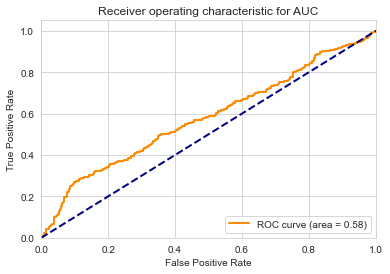

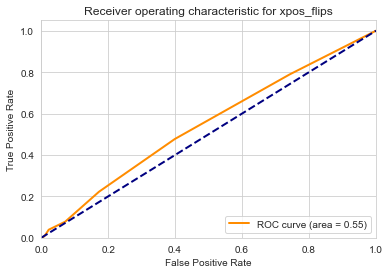

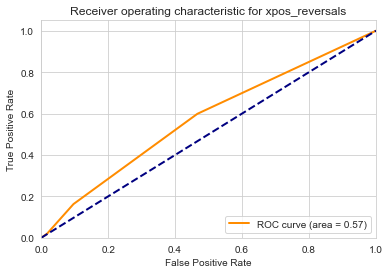

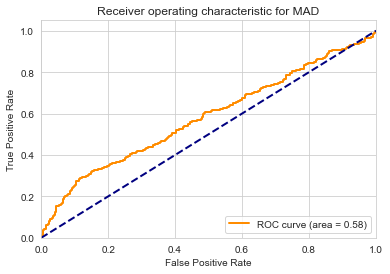

0.5813191673180566

In [844]:

alternative_measures(measure= "AUC", data = spivey_all_measures, labels= y_spivey2) #AUC 

alternative_measures(measure="xpos_flips", data = spivey_all_measures, labels= y_spivey2) #change of direction

alternative_measures(measure="xpos_reversals", data = spivey_all_measures, labels= y_spivey2) #Time it cross the y-axis. 

alternative_measures(measure="MAD", data = spivey_all_measures, labels= y_spivey2) #Maximum absouloute deviation


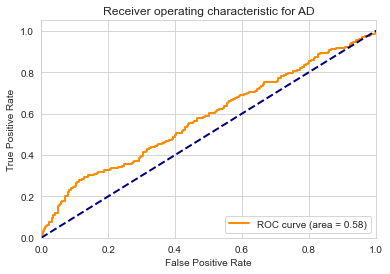

0.5800129592298515

In [845]:
alternative_measures(measure= "AD",data = spivey_all_measures, labels= y_spivey2) #Average Deviation. 

In [846]:
# baseline 

def baseline(y_list):
    y_spivey2_copy = y_list.copy()

    roc_auc_list = []

    for i in range(2500):
        np.random.shuffle(y_spivey2_copy)
        fpr, tpr, _ = roc_curve(y_list, y_spivey2_copy)
        roc_auc_list.append(auc(fpr,tpr))

    baseline_auc = np.mean(roc_auc_list)
    baseline_auc_std = np.std(roc_auc_list)
    return baseline_auc , baseline_auc_std

baseline(y_list= y_spivey2)

(0.4997316102357346, 0.017129259750662415)

In [830]:
# TOPLINE
def topline(n_compon, data_train , y_train):
    sc = StandardScaler()
    pc = PCA(n_components = n_compon)
    lda = LinearDiscriminantAnalysis()

    #Standardize
    train_sc = sc.fit_transform(data_train)

    #PCA 
    train_pc = pc.fit_transform(train_sc)
  

    #lda
    lda.fit(train_pc, y_train)
    lda_score_y_test = lda.decision_function(train_pc)
    fpr, tpr, _  = roc_curve(y_train , lda_score_y_test)
    auc_score = auc(fpr, tpr)

    return auc_score

topline(n_compon= 13, data_train= X_spivey, y_train= y_spivey2)

0.5962685646110174

# BOOTSTRAP TIME

In [831]:
## Bootstrap time 
#random data
x_lul = np.random.normal(loc= 300.0, size=1000)

sample_mean = []
 
for i in range(100):
  y = random.sample(x_lul.tolist(), 100)
  avg = np.mean(y)
  sample_mean.append(avg)


np.mean(sample_mean)

300.0464792614537

6


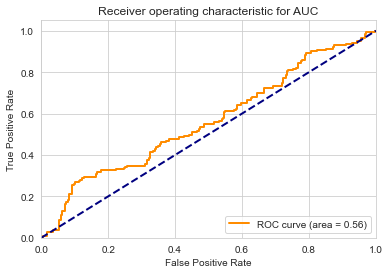

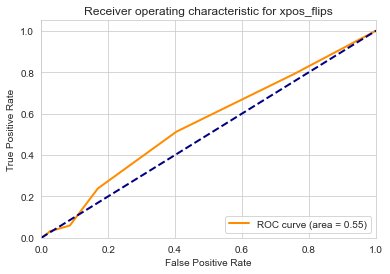

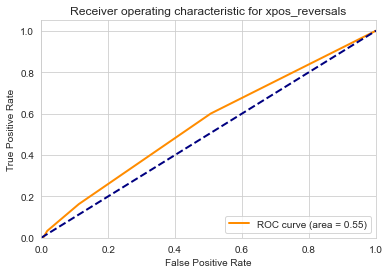

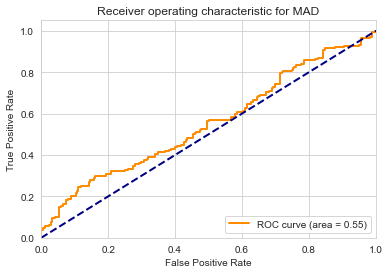

/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


7


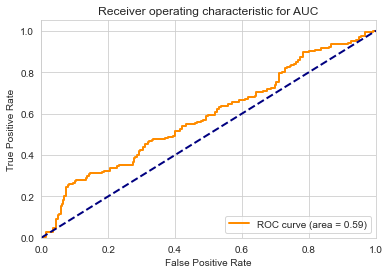

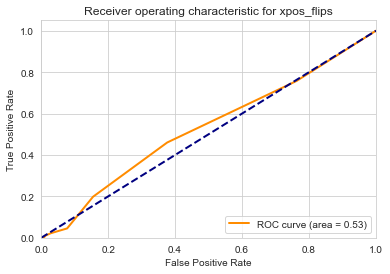

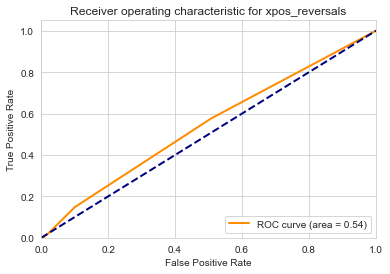

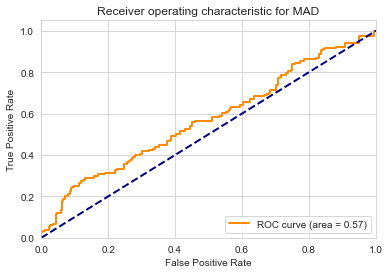

/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


8


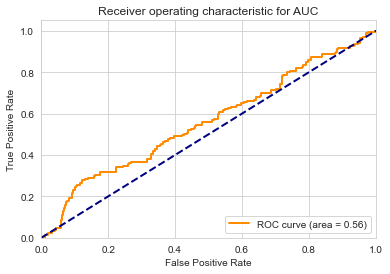

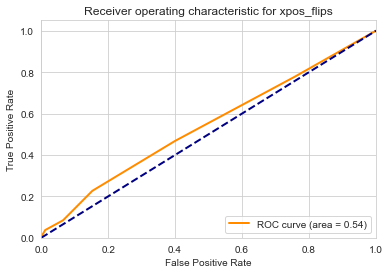

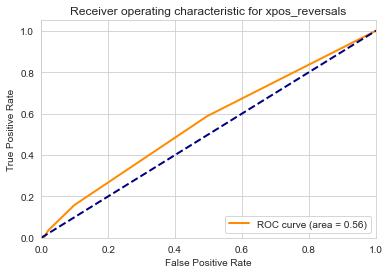

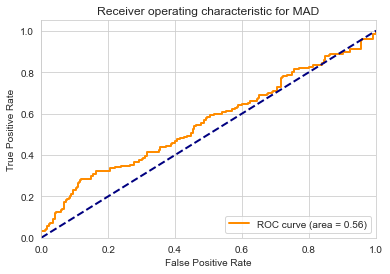

/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


9


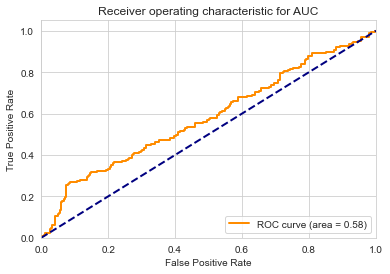

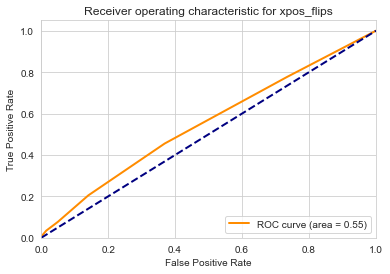

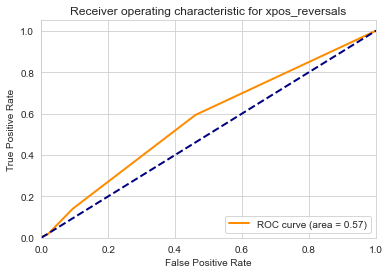

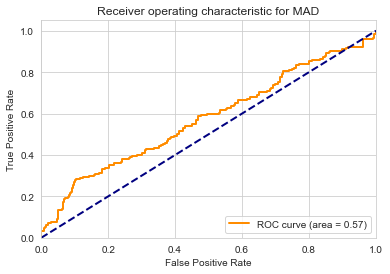

/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


10


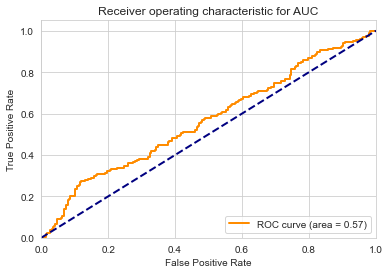

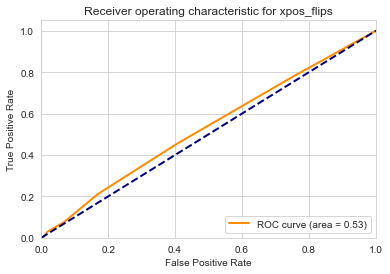

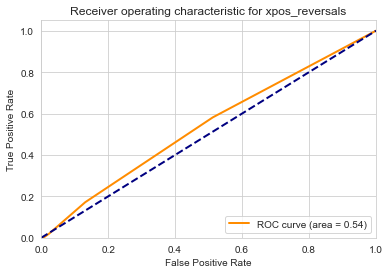

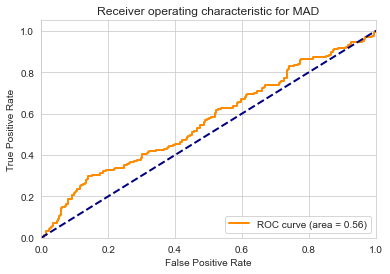

/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


11


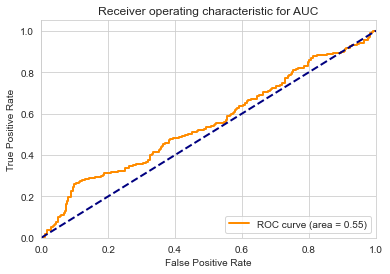

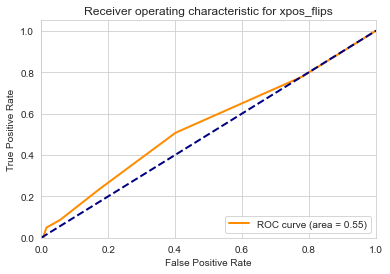

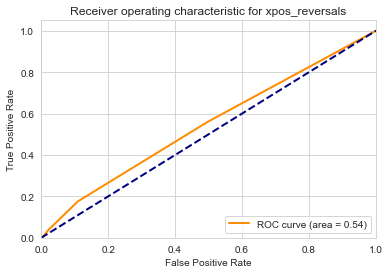

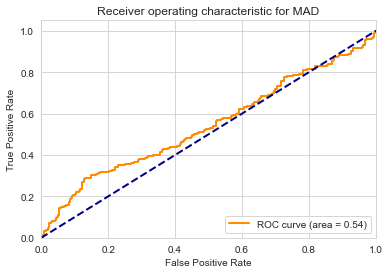

/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


12


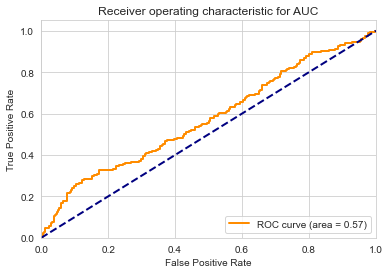

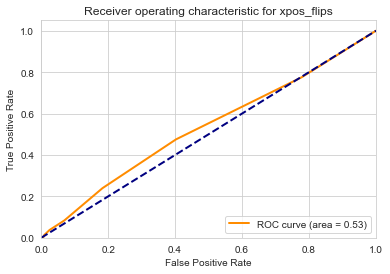

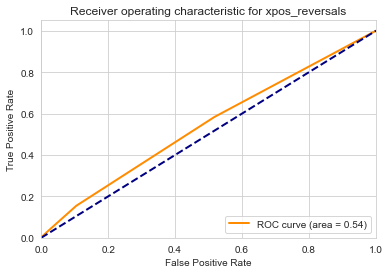

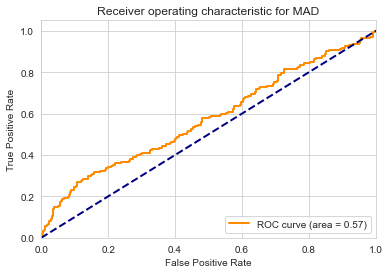

/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


13


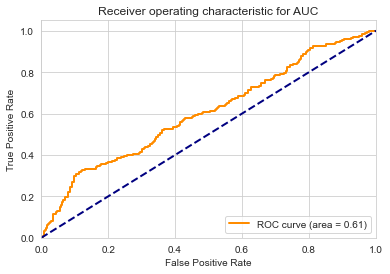

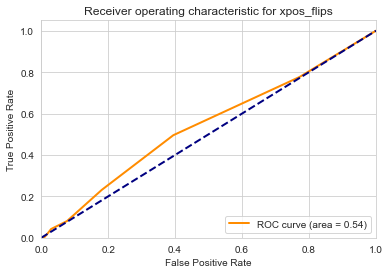

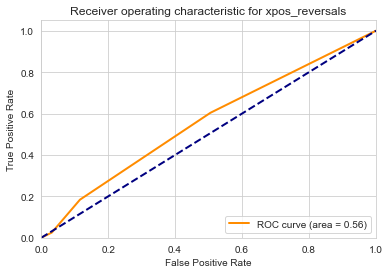

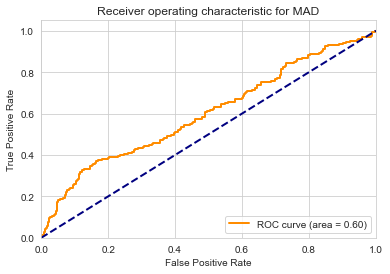

/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


14


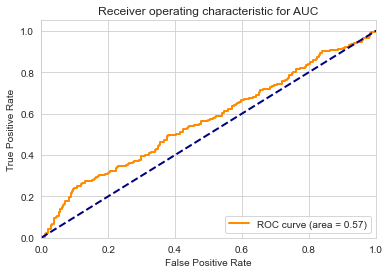

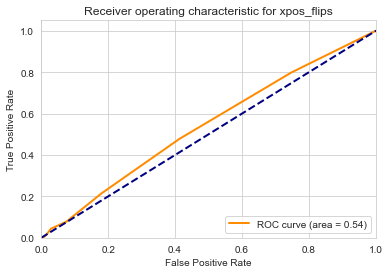

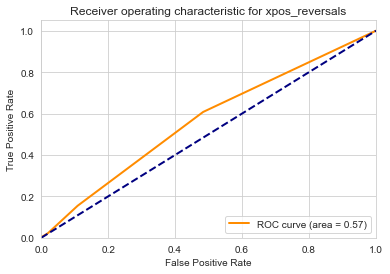

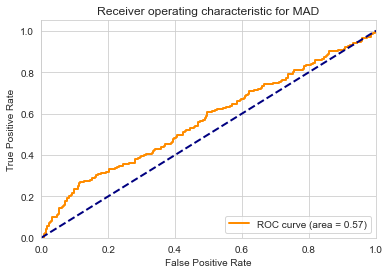

/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [847]:
from sklearn.utils import resample


#Bootstrap / resample. 
subjects = np.unique(spivey_all_measures.loc[:,["Subject"]]) #Find all possible Subject values

def bootstuff():
    AUC_list = []
    xpos_flips_list = []
    xpos_reversals_list = []
    MAD_list = []
    full_LDA_list = []
    coord_LDA_list = []
    topline_list = []
    baseline_list = []
    n_subjects = []
    
    for i in range(5,len(subjects)):
        #Iteration and number of subjects
        i = i + 1
        n_subjects.append(i)
        #Subset and bootstrap for all measures
        spivey_sub_index = spivey_all_measures.loc[spivey_all_measures["Subject"].isin(subjects[0:i])].index.values
        spivey_sub = spivey_all_measures.iloc[spivey_sub_index,:]
        y_spivey2_sub = y_spivey2[spivey_sub_index]
      
        spivey_sub_boot, y_spivey2_sub_boot = resample(spivey_sub, y_spivey2_sub, n_samples= 2000, stratify= spivey_sub.loc[:,["Polarity"]])
        
        #START OF STATISICAL AUC TEST.
        print(i) #print iteration
        AUC_list.append(alternative_measures("AUC", data = spivey_sub_boot , labels= y_spivey2_sub_boot)) #AUC 

        xpos_flips_list.append(alternative_measures("xpos_flips", data = spivey_sub_boot , labels= y_spivey2_sub_boot)) #change of direction

        xpos_reversals_list.append(alternative_measures("xpos_reversals", data = spivey_sub_boot, labels= y_spivey2_sub_boot)) #Time it cross the y-axis. 

        MAD_list.append(alternative_measures("MAD",  data = spivey_sub_boot , labels= y_spivey2_sub_boot)) #Maximum absouloute deviation
        
        #LDA full
        X_spivey_sub = X_spivey.iloc[spivey_sub_index,:]
        X_spivey_sub_boot, y_spivey2_sub_boot_LDA = resample(X_spivey_sub, y_spivey2_sub, n_samples= 2000)


        full_LDA_list.append(train_test(n_compon= 13 , data_train= X, data_test = X_spivey_sub_boot, y_train= y_2, y_test = y_spivey2_sub_boot_LDA))

        #topline 
        topline_list.append(topline(n_compon= 13, data_train= X_spivey_sub_boot, y_train= y_spivey2_sub_boot_LDA))

        #baseline
        baseline_list.append(baseline(y_spivey2_sub_boot_LDA)[0])
        #LDA coords
        X_spivey_coord_sub = X_coord_spivey[spivey_sub_index,:]
        X_spivey_coord_sub_boot, y_spivey2_sub_coord_boot_LDA = resample(X_spivey_coord_sub, y_spivey2_sub, n_samples= 2000)

        coord_LDA_list.append(train_test(n_compon= 13 , data_train= X_coord, data_test= X_spivey_coord_sub_boot, y_train = y_2, y_test = y_spivey2_sub_coord_boot_LDA))


    final_auc_data = pd.DataFrame(
        {'n_subjects': n_subjects,
        'AUC_AUROC': AUC_list,
        'xpos_flips_AUROC': xpos_flips_list,
        'xpos_reversals_AUROC': xpos_reversals_list,
        'MAD_AUROC': MAD_list,
        'full_LDA_AUROC': AUC_list,
        'coord_LDA_AUROC': xpos_flips_list,
        'topline_AUROC': topline_list,
        'baseline_AUROC': baseline_list
        })
    return final_auc_data



auc_boot_models = bootstuff()




In [842]:
auc_boot_models


,0,1,2,3,4,5,6,7,8
0,10.000000,0.574512,0.540939,0.557907,0.568517,0.574512,0.540939,0.604253,0.500040
1,8.210773,0.564182,0.534678,0.547150,0.557421,0.564182,0.534678,0.597883,0.499846
2,11.789227,0.584842,0.547200,0.568664,0.579613,0.584842,0.547200,0.610623,0.500235


In [ ]:
#mean and confidence intervals. 
mean = auc_boot_models.mean()

lower = auc_boot_models.mean() - auc_boot_models.sem()*1.96

upper = auc_boot_models.mean() + auc_boot_models.sem()*1.96



pd.DataFrame(np.row_stack((mean,lower,upper)))

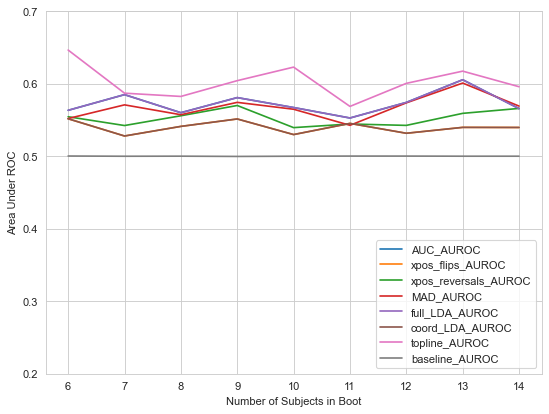

In [848]:
plt.figure(figsize=(8, 6), dpi=80)
for i in range(1,9):
    plt.plot(auc_boot_models.iloc[:,0], auc_boot_models.iloc[:,i], label = auc_boot_models.columns[i])
plt.legend(loc = "lower right")
plt.ylim(0.2,.7)
plt.ylabel("Area Under ROC")
plt.xlabel("Number of Subjects in Boot")
plt.show()

# TIME FOR OTHER MODELS!! <3 <3 <3 <3 <3

In [776]:
from sklearn.linear_model import LogisticRegression

def train_test_lr(n_compon, data_train , data_test, y_train, y_test):
    sc = StandardScaler()
    pc = PCA(n_components = n_compon)
    lr = LogisticRegression()

    #Standardize
    train_sc = sc.fit_transform(data_train)
    test_sc = sc.transform(data_test)

    #PCA 
    train_pc = pc.fit_transform(train_sc)
    test_pc = pc.transform(test_sc)


    #lda
    lr.fit(train_pc, y_train)
    lr_score_y_test = lr.decision_function(test_pc)
    fpr, tpr, _  = roc_curve(y_test , lr_score_y_test)
    auc_score = auc(fpr, tpr)

    return auc_score


train_test_lr(n_compon= 13, data_train= X, data_test= X_spivey, y_train= y_2, y_test= y_spivey2)




/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


0.554624182334307

In [777]:
from sklearn import svm 
svm.SVC()
def train_test_svm(n_compon, data_train , data_test, y_train, y_test):
    sc = StandardScaler()
    pc = PCA(n_components = n_compon)
    sv = svm.SVC(kernel= "rbf", degree= 10, C = 2 )

    #Standardize
    train_sc = sc.fit_transform(data_train)
    test_sc = sc.transform(data_test)

    #PCA 
    train_pc = pc.fit_transform(train_sc)
    test_pc = pc.transform(test_sc)


    #lda
    sv.fit(train_pc, y_train)
    sv_score_y_test = sv.decision_function(test_pc)
    fpr, tpr, _  = roc_curve(y_test , sv_score_y_test)
    auc_score = auc(fpr, tpr)

    return auc_score


train_test_svm(n_compon= 13, data_train= X, data_test= X_spivey, y_train = y_2, y_test= y_spivey2)

/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


0.5771614144073725

In [778]:
print(train_test_svm(n_compon= 13, data_train= X_vel, data_test = X_vel_spivey, y_train= y_2 , y_test = y_spivey2))

print(train_test_svm(n_compon= 13, data_train= X_acc, data_test = X_acc_spivey, y_train= y_2 , y_test = y_spivey2))

print(train_test_svm(n_compon= 13, data_train= X_vel_acc, data_test = X_vel_acc_spivey, y_train= y_2 , y_test = y_spivey2))

0.5421174970173201
0.49787612621878474
0.5256407619204344
